#### Python Modules

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

# use_gpu = torch.cuda.is_available()
# if use_gpu:
#     print("Using CUDA")
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [2]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

### Dataset loader
The dataset is divided in three categories: training, validation and test.

The first one will be, obviously, used for trainig; the validation set will be used to measure the model performance during training and the test set will be used to evaluate our model performance once the training has finished.

_Note:_ These three sets should all contain different images.

Loading this dataset with pytorch is really easy using <u>[ImageFolder](https://pytorch.org/docs/master/torchvision/datasets.html#imagefolder)</u> as the labels are specified by the folders names.

In [3]:
data_dir = 'flowers'
TRAIN = 'train'
VAL = 'valid'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally.
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print(f"Loaded {dataset_sizes[x]} images under {x}")

# Folder structure with 'train' as root dir is like: train/1/x.png, train/2/y.png, ..., train/102/xxx.png
# dataset.classes => gives array of ['1', '10', '100', ..., '99'] sorted by string values
#   in order to get sorted by int values, torchvision>dataset>folder.py module overwrited as below
#
### ..\anaconda3\envs\py38_env\Lib\site-packages\torchvision\datasets\folder.py
#
# def find_classes(directory: Union[str, Path]) -> Tuple[List[str], Dict[str, int]]:
#     """Finds the class folders in a dataset.

#     See :class:`DatasetFolder` for details.
#     """
#     this line added >>> is_alldir_numeric = np.prod([entry.name.isnumeric() for entry in os.scandir(directory) if entry.is_dir()])
#     this line modified >>> classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()], key=lambda k: int(k) if is_alldir_numeric else k)
#     ...
#     return classes, class_to_idx
#                    
class_names =image_datasets[TRAIN].classes
print(f"Classes: {class_names}")
class_names_txt = [cat_to_name[c] for c in class_names]
print(f"Classes as text: {class_names_txt}")

Loaded 6552 images under train
Loaded 818 images under valid
Loaded 819 images under test
Classes: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102']
Classes as text: ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purpl

### Utils

Some utility function to visualize the dataset and the model's predictions

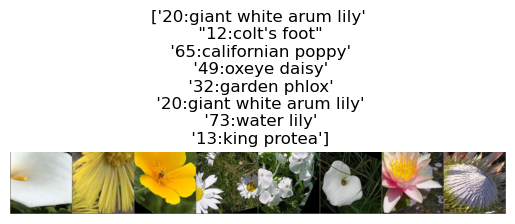

In [4]:
def imshow(inp, title=None):
    # inp.shape => torch.Size([3, 228, 1810]) 
    # => [0]: ch = 3, [1]: h = 228, [2]: w = 1810
    # For plt.imshow(inp) => inp must be like (0:h (rows), 1:w (cols), 2:ch) => (228, 1810, 3)
    # Transpose set new indices (0, 1, 2) to orj indices (1:h , 2:w, 0:ch)  
    if not type(inp) is type(np.ndarray(1)):
        # if type of inp is not a numpy array
        inp = inp.numpy().transpose((1, 2, 0))
    else:
        # if type of inp is a numpy array
        inp = inp.transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    
    # Image needs to be clipped between 0 and 1
    inp = np.clip(inp, 0, 1)
    
    plt.axis('off')
    # Require (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
def imshow_preprocess(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    title_list = [f'{class_names[x]}:{class_names_txt[x]}' for x in classes]
    title = '\n'.join(str(title_list).split(','))
    imshow(out, title=title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    
    # Set model for evaluation
    model.train(False)
    model.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        # if i == 0:
        #     print(inputs)
        
        with torch.no_grad():
            # if use_gpu:
            #     inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            # else:
            #     inputs, labels = Variable(inputs), Variable(labels)
            inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
            model.to(device)
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            predicted_labels = [preds[j] for j in range(inputs.size()[0])]
            
            print("Ground truth:")
            show_databatch(inputs.data.cpu(), labels.data.cpu())
            print("Prediction:")
            show_databatch(inputs.data.cpu(), predicted_labels)
            
            del inputs, labels, outputs, preds, predicted_labels
            torch.cuda.empty_cache()
            
            images_so_far += size
            if images_so_far >= num_images:
                break
        
    model.train(mode=was_training) # Revert model back to original train

This helper function will give us the accuracy of our model on the test set.

In [9]:
def eval_model(model, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        model.train(False)
        model.eval()
        inputs, labels = data

        with torch.no_grad():
            # if use_gpu:
            #     inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            # else:
            #     inputs, labels = Variable(inputs), Variable(labels)
            inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

            outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss_test += loss.item()
            acc_test += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

### Model creation
The [VGG-16](https://www.quora.com/What-is-the-VGG-neural-network) is able to classify 1000 different labels; we just need 102 instead. In order to do that we are going replace the last fully connected layer of the model with a new one with 102 output features instead of 1000.

In PyTorch, we can access the VGG-16 classifier with `model.classifier`, which is an 6-layer array. We will replace the last entry.

We can also disable training for the convolutional layers setting `require_grad = False`, as we will only train the fully connected classifier.

In [10]:
# Load the pretrained model from pytorch
# pretrained=True arg is depreceated, instead weights=models.VGG16_BN_Weights.DEFAULT arg is used to load pretrained model
# Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to C:\Users\kahra/.cache\torch\hub\checkpoints\vgg16_bn-6c64b313.pth
model_pretrain = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)
# # .pth file is downloaded from https://pytorch.org/vision/0.8/_modules/torchvision/models/vgg.html 
# # and saved to the path below
# model_pretrain.load_state_dict(torch.load("./input/vgg16bn/vgg16_bn.pth"))
print(model_pretrain.classifier[6].out_features) # 1000 

# Freeze training for all layers
for param in model_pretrain.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = model_pretrain.classifier[6].in_features
features = list(model_pretrain.classifier.children())[:-1] # Remove last layer
features.extend([# nn.Linear(num_features, 512), nn.ReLU(inplace=True), nn.Dropout(p=0.2),
                 nn.Linear(num_features, len(class_names)), nn.LogSoftmax(dim=1)]) # Add our layer with 102 outputs
model_pretrain.classifier = nn.Sequential(*features) # Replace the model classifier
print(model_pretrain)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

The output above is the summary of our model. Notice how the last layer has 102 output features as we specified.

In [11]:
# # If you want to train the model for more than 2 epochs, set this to True after the first run
# resume_training = False

# if resume_training:
#     print("Loading pretrained model..")
#     vgg16.load_state_dict(torch.load('../input/vgg16-transfer-learning-pytorch/VGG16_v2-OCT_Retina.pt'))
#     print("Loaded!")

We will also define our loss function (cross entropy) and the optimizer.

The learning rate will start at 0.001 and a StepLR object will decrese it by a factor of 0.1 every 7 epochs (not really needed here as we're training for 3 epochs only)

For further details refer to https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [12]:
# if use_gpu:
#     model_pretrain.cuda() #.cuda() will move everything to the GPU side
model_pretrain.to(device)
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_pretrain.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Model evaluation and visualization (before training)
Let's see how our model performs before any training

In [13]:
print("Test before training")
eval_model(model_pretrain, criterion)

Test before training
Evaluating model
----------
Test batch 100/103
Evaluation completed in 0m 7s
Avg loss (test): 0.5891
Avg acc (test): 0.0098
----------


Ground truth:


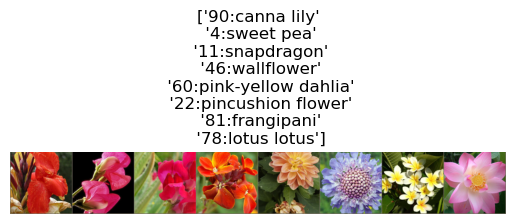

Prediction:


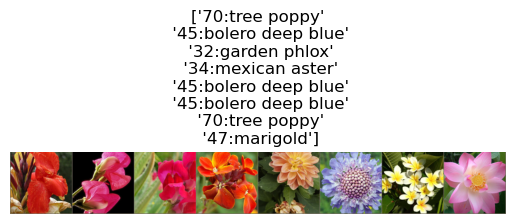

In [14]:
visualize_model(model_pretrain) #test before training

Not really great results. Let's see if it can do better after training

### Training
What follows is [pretty standard pytorch code for training](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

For every epoch we iterate over all the training batches, compute the loss , and adjust the network weights with `loss.backward()` and `optimizer.step()`. Then we evaluate the performance over the validaton set. At the end of every epoch we print the network progress (loss and accuracy). The accuracy will tell us how many predictions were correct.

As we said before, transfer learning can work on smaller dataset too, so for every epoch we only iterate over half the trainig dataset (worth noting that it won't exactly be half of it over the entire training, as the data is shuffled, but it will almost certainly be a subset)

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        model.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)
                
            # Use half training dataset
            if i >= train_batches / 2:
                break
                
            inputs, labels = data
            
            # if use_gpu:
            #     inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            # else:
            #     inputs, labels = Variable(inputs), Variable(labels)
            inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            # scheduler.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / dataset_sizes[TRAIN]
        avg_acc = acc_train * 2 / dataset_sizes[TRAIN]
        
        model.train(False)
        model.eval()
            
        for i, data in enumerate(dataloaders[VAL]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            with torch.no_grad():
            #   if use_gpu:
            #       inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            #   else:
            #       inputs, labels = Variable(inputs), Variable(labels)
              inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
              
              optimizer.zero_grad()
              
              outputs = model(inputs)
              
              _, preds = torch.max(outputs.data, 1)
              loss = criterion(outputs, labels)
              
              loss_val += loss.item()
              acc_val += torch.sum(preds == labels.data)
              
              del inputs, labels, outputs, preds
              torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val / dataset_sizes[VAL]
        
        print()
        print("Epoch {} result: ".format(epoch+1))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        # Check if the avg accuracy at the end of current epoch is higher than 
        # the best accuracy until that epoch, if so, set it as new best accuracy value
        # and make a copy of the state dict of the model 
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [16]:
model_trained = train_model(model_pretrain, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=3)

Epoch 1/3
----------
Training batch 400/409.5
Validation batch 100/103
Epoch 1 result: 
Avg loss (train): 0.3370
Avg acc (train): 0.3898
Avg loss (val): 0.0902
Avg acc (val): 0.7983
----------

Epoch 2/3
----------
Training batch 400/409.5
Validation batch 100/103
Epoch 2 result: 
Avg loss (train): 0.1543
Avg acc (train): 0.6737
Avg loss (val): 0.0550
Avg acc (val): 0.8778
----------

Epoch 3/3
----------
Training batch 400/409.5
Validation batch 100/103
Epoch 3 result: 
Avg loss (train): 0.1164
Avg acc (train): 0.7531
Avg loss (val): 0.0388
Avg acc (val): 0.9120
----------


Training completed in 3m 2s
Best acc: 0.9120


### Model evaluation and visualization (after training)
Let's evaluate our model again after 3 epochs of training

In [17]:
eval_model(model_trained, criterion)

Evaluating model
----------
Test batch 100/103
Evaluation completed in 0m 7s
Avg loss (test): 0.0395
Avg acc (test): 0.8987
----------


Now that's a pretty good result!

Ground truth:


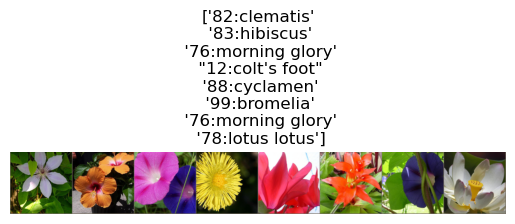

Prediction:


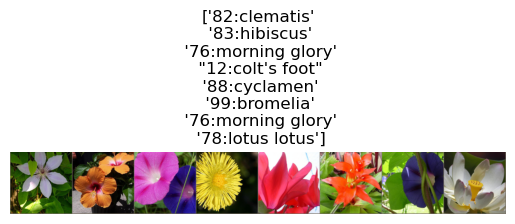

Ground truth:


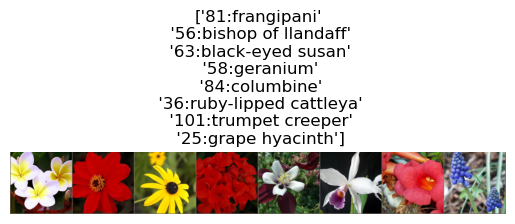

Prediction:


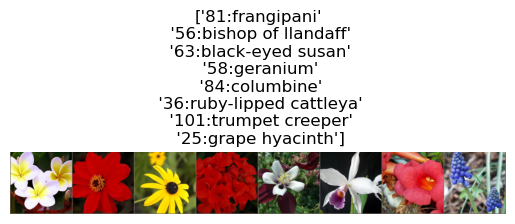

In [18]:
visualize_model(model_trained, num_images=16)

### Save the Model

In [26]:
model_trained.class_to_idx = image_datasets[TRAIN].class_to_idx
# print(model_trained.class_to_idx)
model_trained.cpu()
torch.save({'arch': 'vgg16_bn',
            'state_dict': model_trained.state_dict(), 
            'class_to_idx': model_trained.class_to_idx}, 
            'model_vgg16_flowerclass.pth')

### Load a Saved Checkpoint and Evaluate

In [20]:
def load_checkpoint(path):
    checkpoint = torch.load(path)
    
    if checkpoint['arch'] == 'vgg16_bn':
        model = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Sorry base architecture note recognized")
        return None
    
    model.class_to_idx = checkpoint['class_to_idx']
    
    # Create the classifier
    num_features = model.classifier[6].in_features
    features = list(model.classifier.children())[:-1] # Remove last layer
    features.extend([nn.Linear(num_features, len(class_names)), nn.LogSoftmax(dim=1)]) # Add our layer with 102 outputs
    model.classifier = nn.Sequential(*features) # Replace the model classifier
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

### Image Processing

In [21]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path).convert('RGB')
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((9999, 256))
    else:
        img.thumbnail((256, 9999))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    # print('PIL image shape: ', img.shape)
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    # print('Transposed shape: ', img.shape)
    # print(img)
    return img

In [22]:
def random_img_path(imgset=TEST):
  path = os.path.join(data_dir, imgset)
  list_dir_class = os.listdir(path)
  rand_class = list_dir_class[np.random.randint(0, len(list_dir_class))]
  path_rand_class = os.path.join(path, rand_class)
  list_dir_img = os.listdir(path_rand_class)
  rand_img = list_dir_img[np.random.randint(0, len(list_dir_img))]
  path_rand_img = os.path.join(path_rand_class, rand_img)
  return path_rand_img


### Class Prediction

In [ ]:
# TODO: This is where I left off on August 16, 2024

def predict(image_path, checkpoint, top_k=5):
    model = load_checkpoint(checkpoint)
    # model.to(device)
    # visualize_model(model)
    model.cpu()
    
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    print(image_tensor)
    # Add batch of size 1 to image
    input_model = image_tensor.unsqueeze(0)
    
    # Probs
    ps = torch.exp(model(input_model))
    print(ps)
    
    # Top probs
    top_ps, top_cats = ps.topk(top_k)
    print(top_ps)
    top_ps = top_ps.detach().numpy().tolist()[0] 
    top_cats = top_cats.detach().numpy().tolist()[0]
    print(f'class_to_idx: {model.class_to_idx}')
    # Convert indices to classes
    idx_to_class = {val: key for key, val in 
                    model.class_to_idx.items()}
    print(f'idx_to_class: {idx_to_class}')
    print(f'Top 5 categories: {top_cats}')
    top_labels = [idx_to_class[cat] for cat in top_cats]
    top_flowers = [cat_to_name[idx_to_class[cat]] for cat in top_cats]
    print(top_labels)
    
    return img, top_ps, top_labels, top_flowers

flowers\test\77\image_00114.jpg


C:\Users\kahra\AppData\Local\Temp\ipykernel_25328\858205696.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


tensor([[[-0.0458, -0.0972, -0.1486,  ..., -0.0458, -0.0801, -0.0629],
         [-0.0287, -0.0801, -0.1314,  ..., -0.0458, -0.0629,  0.0056],
         [-0.3198, -0.1999, -0.1999,  ..., -0.0287, -0.0458, -0.0287],
         ...,
         [-0.0116,  0.0227,  0.0912,  ..., -0.4054, -0.4568, -0.4397],
         [-0.0801,  0.0056,  0.0056,  ..., -0.4911, -0.4568, -0.4911],
         [-0.1314, -0.1486, -0.1828,  ..., -0.5938, -0.5253, -0.5596]],

        [[ 0.9755,  0.9580,  0.9055,  ..., -0.0049, -0.0399, -0.0224],
         [ 0.9755,  0.9580,  0.9055,  ..., -0.0049, -0.0224,  0.0476],
         [ 0.7479,  0.8354,  0.8179,  ...,  0.0126, -0.0049,  0.0126],
         ...,
         [ 0.1527,  0.1176,  0.1877,  ..., -0.1625, -0.1625, -0.1450],
         [ 0.0476,  0.1527,  0.1527,  ..., -0.2150, -0.1975, -0.2325],
         [ 0.0126, -0.0049, -0.0399,  ..., -0.2500, -0.2675, -0.3025]],

        [[-0.2010, -0.3230, -0.3927,  ...,  0.1128,  0.0779,  0.1128],
         [-0.1661, -0.2532, -0.3055,  ...,  0

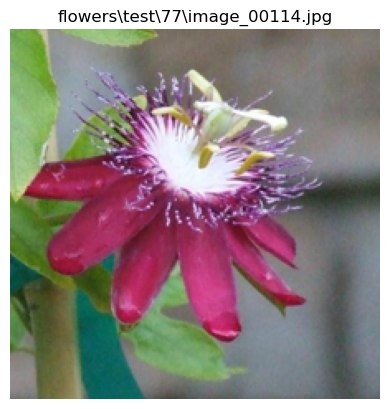

In [24]:
img_path = random_img_path(TEST)
print(img_path)
img, _, _, _ = predict(img_path, 'model_vgg16_flowerclass.pth')
imshow(img, title=img_path)


In [ ]:
visualize_model(model_trained, num_images=8)

In [ ]:
# # THIS CELL CALCULATES IMAGE DATASET STATISTICS
# # Image manipulations
# from PIL import Image

# # Empty lists
# categories = []
# img_categories = []
# n_train = []
# n_valid = []
# n_test = []
# hs = []
# ws = []

# # sort the strings by the integer contained within the string
# def extract_integer(fname):
#     return int(fname)
# # sorted(os.listdir(), key=extract_integer)

# # Get category number array by listing directories/folders in train directory 
# cat_nums = sorted(os.listdir(train_dir), key=lambda fname: int(fname))

# # Iterate through each category
# for d in cat_nums:
#     categories.append(d)

#     # Number of each image
#     train_imgs = os.listdir(train_dir+'/'+d)
#     valid_imgs = os.listdir(valid_dir+'/'+d)
#     test_imgs = os.listdir(test_dir+'/'+d)
#     n_train.append(len(train_imgs))
#     n_valid.append(len(valid_imgs))
#     n_test.append(len(test_imgs))

#     # Find stats for train images
#     for i in train_imgs:
#         img_categories.append(d)
#         img = Image.open(train_dir + '/' + d + '/' + i)
#         img_array = np.array(img)
#         # Shape
#         hs.append(img_array.shape[0])
#         ws.append(img_array.shape[1])
        
# # del train_imgs, valid_imgs, test_imgs, img